# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

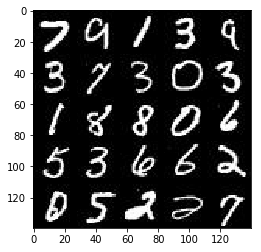

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

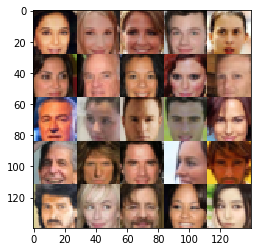

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')    
    lr = tf.placeholder(tf.float32, name = 'learn_rate')
    return inputs_real, inputs_z, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    sd = 0.0125
    with tf.variable_scope('discriminator', reuse = reuse):
        # images shape is 28x28xnum_channels
        conv1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same',
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        relu1 = tf.maximum(alpha * conv1, conv1)
        # 14x14x64      
        conv2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same',
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        norm2 = tf.layers.batch_normalization(conv2, training = True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        # 7x7x128        
        flat = tf.reshape(relu2, (-1, 7 * 7 * 128))
        logits = tf.layers.dense(flat, 1, 
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        out = tf.sigmoid(logits)  
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    sd = 0.0125
    with tf.variable_scope('generator', reuse = not is_train):
        # fully connected layer using noise vector z
        fcon = tf.layers.dense(z, 7 * 7 * 512)
        # reshape and normalize
        shape1 = tf.reshape(fcon, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(shape1, training = is_train)
        relu1 = tf.maximum(alpha * norm1, norm1)
        # 7x7x512 now        
        tcon2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides = 2, padding = 'same',
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        norm2 = tf.layers.batch_normalization(tcon2, training = is_train)
        relu2 = tf.maximum(alpha * norm2, norm2)
        # 14x14x256 now
        tcon3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides = 2, padding = 'same',
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        norm3 = tf.layers.batch_normalization(tcon3, training = is_train)
        relu3 = tf.maximum(alpha * norm3, norm3)
        # 28x28x128 now        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same',
            kernel_initializer = tf.random_normal_initializer(stddev = sd))
        out = tf.tanh(logits)        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_real, labels = tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
        logits = d_logits_fake, labels = tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    losses = []
    steps = 0
    print_every = 25
    show_every = 100
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate, input_real: batch_images})
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{} ".format(epoch_i+1, epochs),
                        "Step {} ...".format(steps),
                        "Discriminator Loss: {:.4f} ".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)
    return losses              

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2  Step 25 ... Discriminator Loss: 1.5798  Generator Loss: 0.5658
Epoch 1/2  Step 50 ... Discriminator Loss: 1.4024  Generator Loss: 0.5660
Epoch 1/2  Step 75 ... Discriminator Loss: 1.6347  Generator Loss: 0.4752
Epoch 1/2  Step 100 ... Discriminator Loss: 1.4959  Generator Loss: 0.6003


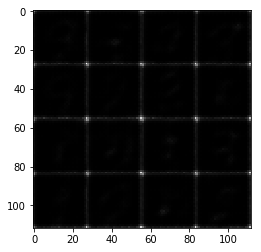

Epoch 1/2  Step 125 ... Discriminator Loss: 1.5330  Generator Loss: 0.5530
Epoch 1/2  Step 150 ... Discriminator Loss: 1.5879  Generator Loss: 0.5352
Epoch 1/2  Step 175 ... Discriminator Loss: 1.4737  Generator Loss: 0.5760
Epoch 1/2  Step 200 ... Discriminator Loss: 1.5732  Generator Loss: 0.5427


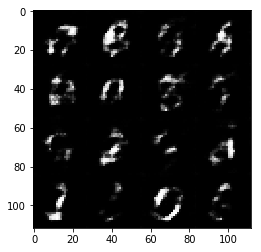

Epoch 1/2  Step 225 ... Discriminator Loss: 1.5016  Generator Loss: 0.5970
Epoch 1/2  Step 250 ... Discriminator Loss: 1.5508  Generator Loss: 0.5527
Epoch 1/2  Step 275 ... Discriminator Loss: 1.3980  Generator Loss: 0.6426
Epoch 1/2  Step 300 ... Discriminator Loss: 1.4036  Generator Loss: 0.6006


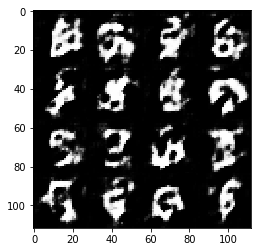

Epoch 1/2  Step 325 ... Discriminator Loss: 1.4122  Generator Loss: 0.6650
Epoch 1/2  Step 350 ... Discriminator Loss: 1.3329  Generator Loss: 0.6242
Epoch 1/2  Step 375 ... Discriminator Loss: 1.3238  Generator Loss: 0.6195
Epoch 1/2  Step 400 ... Discriminator Loss: 1.3370  Generator Loss: 0.6368


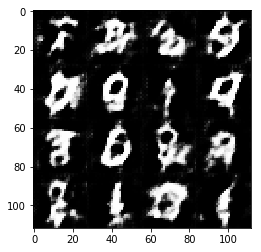

Epoch 1/2  Step 425 ... Discriminator Loss: 1.3895  Generator Loss: 0.6240
Epoch 1/2  Step 450 ... Discriminator Loss: 1.3780  Generator Loss: 0.6705
Epoch 1/2  Step 475 ... Discriminator Loss: 1.3334  Generator Loss: 0.7707
Epoch 1/2  Step 500 ... Discriminator Loss: 1.3896  Generator Loss: 0.6842


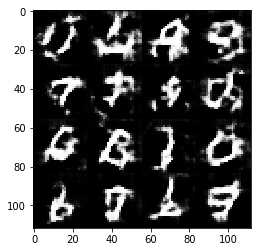

Epoch 1/2  Step 525 ... Discriminator Loss: 1.4788  Generator Loss: 0.4793
Epoch 1/2  Step 550 ... Discriminator Loss: 1.4676  Generator Loss: 0.5358
Epoch 1/2  Step 575 ... Discriminator Loss: 1.4722  Generator Loss: 0.6363
Epoch 1/2  Step 600 ... Discriminator Loss: 1.3889  Generator Loss: 0.6018


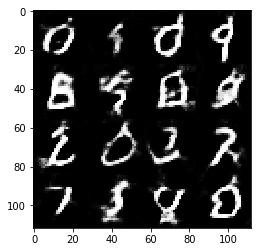

Epoch 1/2  Step 625 ... Discriminator Loss: 1.5008  Generator Loss: 0.6086
Epoch 1/2  Step 650 ... Discriminator Loss: 1.5614  Generator Loss: 0.4563
Epoch 1/2  Step 675 ... Discriminator Loss: 1.4502  Generator Loss: 0.6039
Epoch 1/2  Step 700 ... Discriminator Loss: 1.3224  Generator Loss: 0.5997


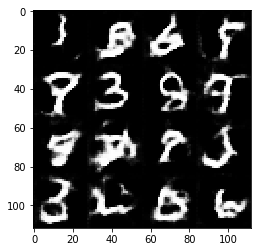

Epoch 1/2  Step 725 ... Discriminator Loss: 1.3841  Generator Loss: 0.6488
Epoch 1/2  Step 750 ... Discriminator Loss: 1.4462  Generator Loss: 0.7159
Epoch 1/2  Step 775 ... Discriminator Loss: 1.4650  Generator Loss: 0.5882
Epoch 1/2  Step 800 ... Discriminator Loss: 1.4835  Generator Loss: 0.6436


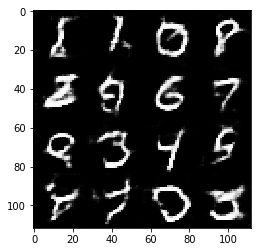

Epoch 1/2  Step 825 ... Discriminator Loss: 1.3322  Generator Loss: 0.7160
Epoch 1/2  Step 850 ... Discriminator Loss: 1.3253  Generator Loss: 0.6848
Epoch 1/2  Step 875 ... Discriminator Loss: 1.3099  Generator Loss: 0.6754
Epoch 1/2  Step 900 ... Discriminator Loss: 1.3093  Generator Loss: 0.7413


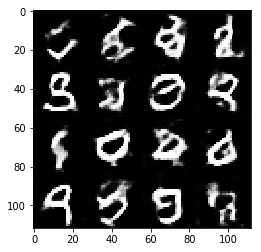

Epoch 1/2  Step 925 ... Discriminator Loss: 1.3560  Generator Loss: 0.5901
Epoch 1/2  Step 950 ... Discriminator Loss: 1.2869  Generator Loss: 0.7626
Epoch 1/2  Step 975 ... Discriminator Loss: 1.2698  Generator Loss: 0.8166
Epoch 1/2  Step 1000 ... Discriminator Loss: 1.3692  Generator Loss: 0.6168


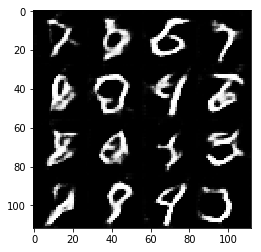

Epoch 1/2  Step 1025 ... Discriminator Loss: 1.3644  Generator Loss: 0.6852
Epoch 1/2  Step 1050 ... Discriminator Loss: 1.4166  Generator Loss: 0.6702
Epoch 1/2  Step 1075 ... Discriminator Loss: 1.3017  Generator Loss: 0.6517
Epoch 1/2  Step 1100 ... Discriminator Loss: 1.4246  Generator Loss: 0.6059


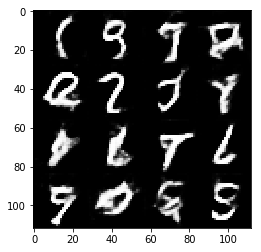

Epoch 1/2  Step 1125 ... Discriminator Loss: 1.2718  Generator Loss: 0.7128
Epoch 1/2  Step 1150 ... Discriminator Loss: 1.3550  Generator Loss: 0.6826
Epoch 1/2  Step 1175 ... Discriminator Loss: 1.5483  Generator Loss: 0.6166
Epoch 1/2  Step 1200 ... Discriminator Loss: 1.3966  Generator Loss: 0.6651


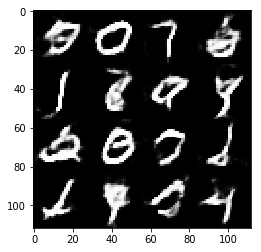

Epoch 1/2  Step 1225 ... Discriminator Loss: 1.2216  Generator Loss: 0.7911
Epoch 1/2  Step 1250 ... Discriminator Loss: 1.3835  Generator Loss: 0.5426
Epoch 1/2  Step 1275 ... Discriminator Loss: 1.2227  Generator Loss: 0.6800
Epoch 1/2  Step 1300 ... Discriminator Loss: 1.3656  Generator Loss: 0.6068


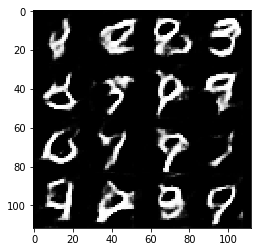

Epoch 1/2  Step 1325 ... Discriminator Loss: 1.3010  Generator Loss: 0.7487
Epoch 1/2  Step 1350 ... Discriminator Loss: 1.3330  Generator Loss: 0.5767
Epoch 1/2  Step 1375 ... Discriminator Loss: 1.3616  Generator Loss: 0.7521
Epoch 1/2  Step 1400 ... Discriminator Loss: 1.2688  Generator Loss: 0.6710


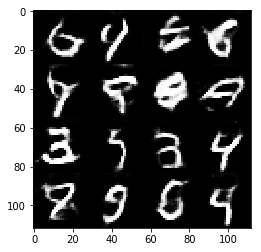

Epoch 1/2  Step 1425 ... Discriminator Loss: 1.2331  Generator Loss: 0.7514
Epoch 1/2  Step 1450 ... Discriminator Loss: 1.3364  Generator Loss: 0.4853
Epoch 1/2  Step 1475 ... Discriminator Loss: 1.2858  Generator Loss: 0.7526
Epoch 1/2  Step 1500 ... Discriminator Loss: 1.1881  Generator Loss: 0.7234


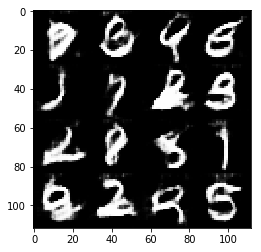

Epoch 1/2  Step 1525 ... Discriminator Loss: 1.1992  Generator Loss: 0.7205
Epoch 1/2  Step 1550 ... Discriminator Loss: 1.3974  Generator Loss: 0.6352
Epoch 1/2  Step 1575 ... Discriminator Loss: 1.3267  Generator Loss: 0.5762
Epoch 1/2  Step 1600 ... Discriminator Loss: 1.4230  Generator Loss: 0.6895


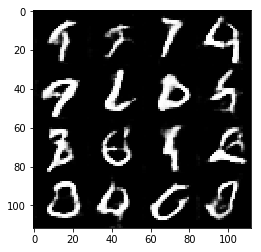

Epoch 1/2  Step 1625 ... Discriminator Loss: 1.3765  Generator Loss: 0.5652
Epoch 1/2  Step 1650 ... Discriminator Loss: 1.2436  Generator Loss: 0.5579
Epoch 1/2  Step 1675 ... Discriminator Loss: 1.4888  Generator Loss: 0.4265
Epoch 1/2  Step 1700 ... Discriminator Loss: 1.2058  Generator Loss: 0.8168


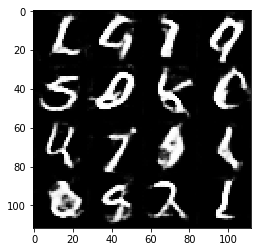

Epoch 1/2  Step 1725 ... Discriminator Loss: 1.2898  Generator Loss: 0.7841
Epoch 1/2  Step 1750 ... Discriminator Loss: 1.2393  Generator Loss: 0.8615
Epoch 1/2  Step 1775 ... Discriminator Loss: 1.2325  Generator Loss: 0.6623
Epoch 1/2  Step 1800 ... Discriminator Loss: 1.3306  Generator Loss: 0.6417


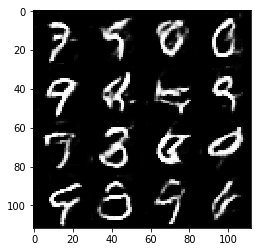

Epoch 1/2  Step 1825 ... Discriminator Loss: 1.3266  Generator Loss: 0.5333
Epoch 1/2  Step 1850 ... Discriminator Loss: 1.2526  Generator Loss: 0.5281
Epoch 1/2  Step 1875 ... Discriminator Loss: 1.2814  Generator Loss: 0.8377
Epoch 2/2  Step 1900 ... Discriminator Loss: 1.2753  Generator Loss: 0.8624


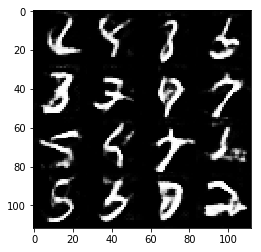

Epoch 2/2  Step 1925 ... Discriminator Loss: 1.2685  Generator Loss: 0.7520
Epoch 2/2  Step 1950 ... Discriminator Loss: 1.2312  Generator Loss: 0.8105
Epoch 2/2  Step 1975 ... Discriminator Loss: 1.3377  Generator Loss: 0.5463
Epoch 2/2  Step 2000 ... Discriminator Loss: 1.4820  Generator Loss: 0.8364


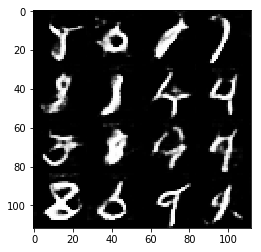

Epoch 2/2  Step 2025 ... Discriminator Loss: 1.2936  Generator Loss: 0.6800
Epoch 2/2  Step 2050 ... Discriminator Loss: 1.4076  Generator Loss: 0.5268
Epoch 2/2  Step 2075 ... Discriminator Loss: 1.4414  Generator Loss: 0.5663
Epoch 2/2  Step 2100 ... Discriminator Loss: 1.2346  Generator Loss: 0.7148


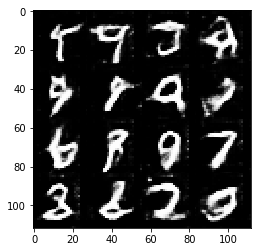

Epoch 2/2  Step 2125 ... Discriminator Loss: 1.3945  Generator Loss: 0.4655
Epoch 2/2  Step 2150 ... Discriminator Loss: 1.1846  Generator Loss: 0.6720
Epoch 2/2  Step 2175 ... Discriminator Loss: 1.2468  Generator Loss: 0.6086
Epoch 2/2  Step 2200 ... Discriminator Loss: 1.2758  Generator Loss: 0.7097


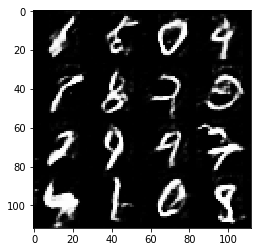

Epoch 2/2  Step 2225 ... Discriminator Loss: 1.2553  Generator Loss: 0.7869
Epoch 2/2  Step 2250 ... Discriminator Loss: 1.5569  Generator Loss: 0.7439
Epoch 2/2  Step 2275 ... Discriminator Loss: 1.4304  Generator Loss: 0.5601
Epoch 2/2  Step 2300 ... Discriminator Loss: 1.3405  Generator Loss: 0.5832


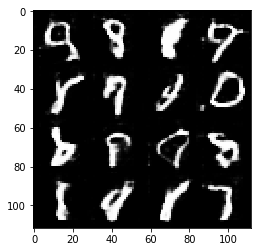

Epoch 2/2  Step 2325 ... Discriminator Loss: 1.3391  Generator Loss: 0.7159
Epoch 2/2  Step 2350 ... Discriminator Loss: 1.2570  Generator Loss: 0.7714
Epoch 2/2  Step 2375 ... Discriminator Loss: 1.3765  Generator Loss: 0.5935
Epoch 2/2  Step 2400 ... Discriminator Loss: 1.3486  Generator Loss: 0.5481


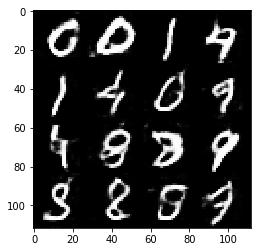

Epoch 2/2  Step 2425 ... Discriminator Loss: 1.3683  Generator Loss: 1.1260
Epoch 2/2  Step 2450 ... Discriminator Loss: 1.3019  Generator Loss: 0.6417
Epoch 2/2  Step 2475 ... Discriminator Loss: 1.1979  Generator Loss: 0.7525
Epoch 2/2  Step 2500 ... Discriminator Loss: 1.3356  Generator Loss: 0.7460


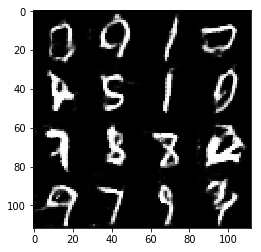

Epoch 2/2  Step 2525 ... Discriminator Loss: 1.3560  Generator Loss: 0.5064
Epoch 2/2  Step 2550 ... Discriminator Loss: 1.2921  Generator Loss: 0.6034
Epoch 2/2  Step 2575 ... Discriminator Loss: 1.2003  Generator Loss: 0.7096
Epoch 2/2  Step 2600 ... Discriminator Loss: 1.2729  Generator Loss: 0.5849


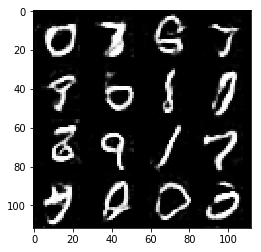

Epoch 2/2  Step 2625 ... Discriminator Loss: 1.2904  Generator Loss: 0.8421
Epoch 2/2  Step 2650 ... Discriminator Loss: 1.4481  Generator Loss: 0.4368
Epoch 2/2  Step 2675 ... Discriminator Loss: 1.3024  Generator Loss: 0.7464
Epoch 2/2  Step 2700 ... Discriminator Loss: 1.3436  Generator Loss: 1.1659


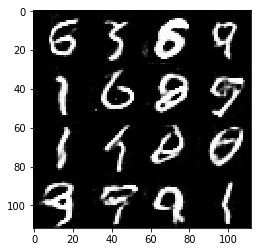

Epoch 2/2  Step 2725 ... Discriminator Loss: 1.3569  Generator Loss: 0.4945
Epoch 2/2  Step 2750 ... Discriminator Loss: 1.3419  Generator Loss: 0.8244
Epoch 2/2  Step 2775 ... Discriminator Loss: 1.3722  Generator Loss: 0.5599
Epoch 2/2  Step 2800 ... Discriminator Loss: 1.2138  Generator Loss: 0.7861


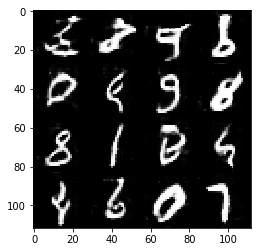

Epoch 2/2  Step 2825 ... Discriminator Loss: 1.2983  Generator Loss: 0.6469
Epoch 2/2  Step 2850 ... Discriminator Loss: 1.4848  Generator Loss: 1.1716
Epoch 2/2  Step 2875 ... Discriminator Loss: 1.2303  Generator Loss: 0.7075
Epoch 2/2  Step 2900 ... Discriminator Loss: 1.2865  Generator Loss: 0.5858


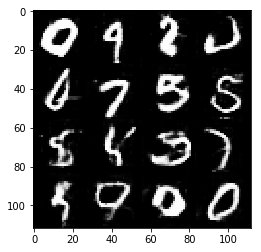

Epoch 2/2  Step 2925 ... Discriminator Loss: 1.2497  Generator Loss: 0.6455
Epoch 2/2  Step 2950 ... Discriminator Loss: 1.2827  Generator Loss: 0.8699
Epoch 2/2  Step 2975 ... Discriminator Loss: 1.2999  Generator Loss: 0.6324
Epoch 2/2  Step 3000 ... Discriminator Loss: 1.3276  Generator Loss: 0.7545


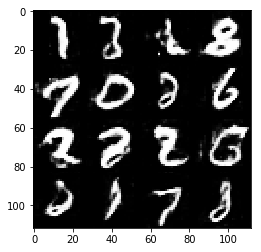

Epoch 2/2  Step 3025 ... Discriminator Loss: 1.2978  Generator Loss: 0.7729
Epoch 2/2  Step 3050 ... Discriminator Loss: 1.3126  Generator Loss: 0.6057
Epoch 2/2  Step 3075 ... Discriminator Loss: 1.2965  Generator Loss: 0.6531
Epoch 2/2  Step 3100 ... Discriminator Loss: 1.2818  Generator Loss: 0.5745


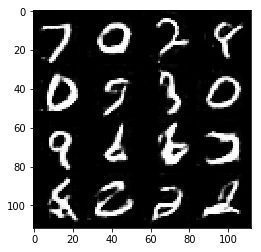

Epoch 2/2  Step 3125 ... Discriminator Loss: 1.3525  Generator Loss: 0.7257
Epoch 2/2  Step 3150 ... Discriminator Loss: 1.3321  Generator Loss: 0.5365
Epoch 2/2  Step 3175 ... Discriminator Loss: 1.1923  Generator Loss: 1.0562
Epoch 2/2  Step 3200 ... Discriminator Loss: 1.2497  Generator Loss: 0.6519


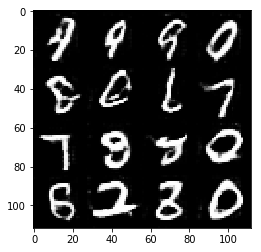

Epoch 2/2  Step 3225 ... Discriminator Loss: 1.2448  Generator Loss: 0.6026
Epoch 2/2  Step 3250 ... Discriminator Loss: 1.1884  Generator Loss: 0.8023
Epoch 2/2  Step 3275 ... Discriminator Loss: 1.1808  Generator Loss: 0.8369
Epoch 2/2  Step 3300 ... Discriminator Loss: 1.2230  Generator Loss: 0.7023


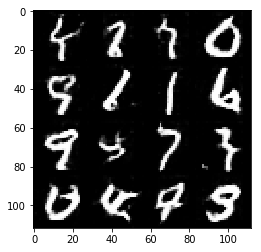

Epoch 2/2  Step 3325 ... Discriminator Loss: 1.4092  Generator Loss: 0.4466
Epoch 2/2  Step 3350 ... Discriminator Loss: 1.2097  Generator Loss: 0.6777
Epoch 2/2  Step 3375 ... Discriminator Loss: 1.3901  Generator Loss: 0.4635
Epoch 2/2  Step 3400 ... Discriminator Loss: 1.4311  Generator Loss: 0.3969


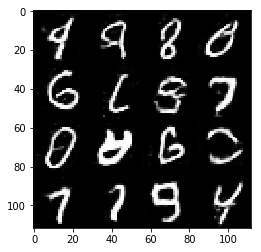

Epoch 2/2  Step 3425 ... Discriminator Loss: 1.1581  Generator Loss: 0.7396
Epoch 2/2  Step 3450 ... Discriminator Loss: 1.2704  Generator Loss: 0.6375
Epoch 2/2  Step 3475 ... Discriminator Loss: 1.2616  Generator Loss: 0.7305
Epoch 2/2  Step 3500 ... Discriminator Loss: 1.2207  Generator Loss: 0.8196


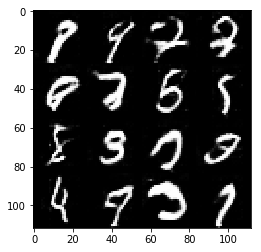

Epoch 2/2  Step 3525 ... Discriminator Loss: 1.3088  Generator Loss: 0.5760
Epoch 2/2  Step 3550 ... Discriminator Loss: 1.0698  Generator Loss: 0.8714
Epoch 2/2  Step 3575 ... Discriminator Loss: 1.2690  Generator Loss: 0.8397
Epoch 2/2  Step 3600 ... Discriminator Loss: 1.2899  Generator Loss: 0.5017


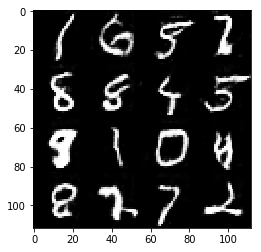

Epoch 2/2  Step 3625 ... Discriminator Loss: 1.4122  Generator Loss: 0.7692
Epoch 2/2  Step 3650 ... Discriminator Loss: 1.4063  Generator Loss: 0.5622
Epoch 2/2  Step 3675 ... Discriminator Loss: 1.1917  Generator Loss: 0.8377
Epoch 2/2  Step 3700 ... Discriminator Loss: 1.2292  Generator Loss: 0.7745


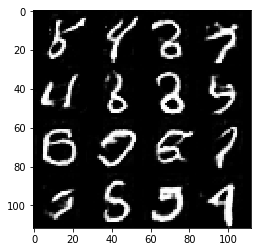

Epoch 2/2  Step 3725 ... Discriminator Loss: 1.2099  Generator Loss: 0.7522
Epoch 2/2  Step 3750 ... Discriminator Loss: 1.2352  Generator Loss: 0.5642


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1  Step 25 ... Discriminator Loss: 1.1198  Generator Loss: 0.5784
Epoch 1/1  Step 50 ... Discriminator Loss: 1.6409  Generator Loss: 0.5018
Epoch 1/1  Step 75 ... Discriminator Loss: 1.5099  Generator Loss: 0.6549
Epoch 1/1  Step 100 ... Discriminator Loss: 1.1313  Generator Loss: 0.7871


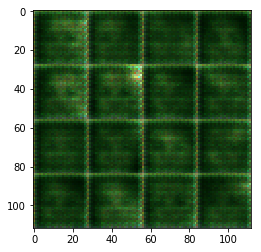

Epoch 1/1  Step 125 ... Discriminator Loss: 1.8219  Generator Loss: 0.3854
Epoch 1/1  Step 150 ... Discriminator Loss: 1.3624  Generator Loss: 0.6026
Epoch 1/1  Step 175 ... Discriminator Loss: 1.2707  Generator Loss: 0.6304
Epoch 1/1  Step 200 ... Discriminator Loss: 1.3546  Generator Loss: 0.7493


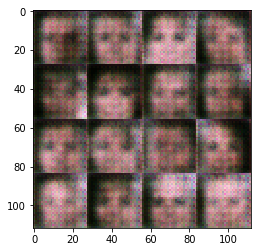

Epoch 1/1  Step 225 ... Discriminator Loss: 1.4543  Generator Loss: 0.5414
Epoch 1/1  Step 250 ... Discriminator Loss: 1.2165  Generator Loss: 0.7262
Epoch 1/1  Step 275 ... Discriminator Loss: 1.2695  Generator Loss: 0.7215
Epoch 1/1  Step 300 ... Discriminator Loss: 1.2159  Generator Loss: 0.7038


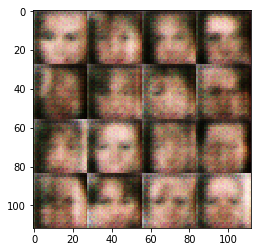

Epoch 1/1  Step 325 ... Discriminator Loss: 0.9776  Generator Loss: 0.9133
Epoch 1/1  Step 350 ... Discriminator Loss: 1.3391  Generator Loss: 0.7297
Epoch 1/1  Step 375 ... Discriminator Loss: 1.3470  Generator Loss: 0.5789
Epoch 1/1  Step 400 ... Discriminator Loss: 0.9356  Generator Loss: 1.3231


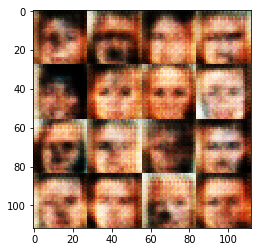

Epoch 1/1  Step 425 ... Discriminator Loss: 1.3595  Generator Loss: 0.4297
Epoch 1/1  Step 450 ... Discriminator Loss: 1.1780  Generator Loss: 0.6434
Epoch 1/1  Step 475 ... Discriminator Loss: 1.2270  Generator Loss: 0.6266
Epoch 1/1  Step 500 ... Discriminator Loss: 1.2166  Generator Loss: 0.6735


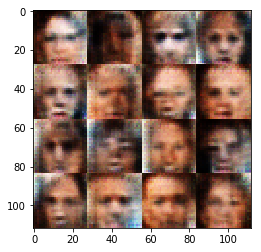

Epoch 1/1  Step 525 ... Discriminator Loss: 0.9461  Generator Loss: 0.9423
Epoch 1/1  Step 550 ... Discriminator Loss: 1.2500  Generator Loss: 0.6956
Epoch 1/1  Step 575 ... Discriminator Loss: 0.7716  Generator Loss: 1.4777
Epoch 1/1  Step 600 ... Discriminator Loss: 0.9968  Generator Loss: 0.7565


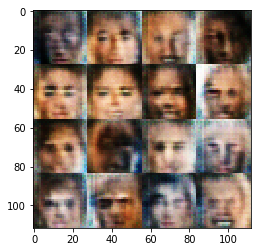

Epoch 1/1  Step 625 ... Discriminator Loss: 1.2951  Generator Loss: 0.6602
Epoch 1/1  Step 650 ... Discriminator Loss: 1.7697  Generator Loss: 0.2764
Epoch 1/1  Step 675 ... Discriminator Loss: 1.3235  Generator Loss: 0.6899
Epoch 1/1  Step 700 ... Discriminator Loss: 1.3654  Generator Loss: 0.7486


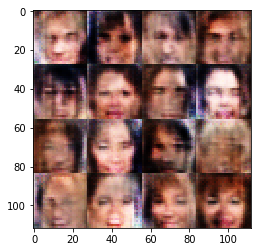

Epoch 1/1  Step 725 ... Discriminator Loss: 1.4531  Generator Loss: 0.5461
Epoch 1/1  Step 750 ... Discriminator Loss: 1.4560  Generator Loss: 0.6010
Epoch 1/1  Step 775 ... Discriminator Loss: 1.5060  Generator Loss: 0.7577
Epoch 1/1  Step 800 ... Discriminator Loss: 1.3621  Generator Loss: 0.8196


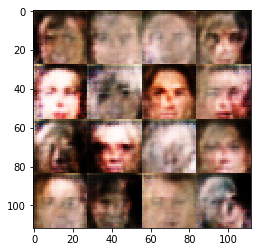

Epoch 1/1  Step 825 ... Discriminator Loss: 1.4014  Generator Loss: 0.5669
Epoch 1/1  Step 850 ... Discriminator Loss: 1.4419  Generator Loss: 0.6660
Epoch 1/1  Step 875 ... Discriminator Loss: 1.5040  Generator Loss: 0.6355
Epoch 1/1  Step 900 ... Discriminator Loss: 1.2845  Generator Loss: 0.8701


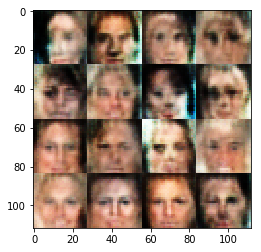

Epoch 1/1  Step 925 ... Discriminator Loss: 1.3548  Generator Loss: 0.7091
Epoch 1/1  Step 950 ... Discriminator Loss: 1.5433  Generator Loss: 0.5295
Epoch 1/1  Step 975 ... Discriminator Loss: 1.4407  Generator Loss: 0.5832
Epoch 1/1  Step 1000 ... Discriminator Loss: 1.3765  Generator Loss: 0.6852


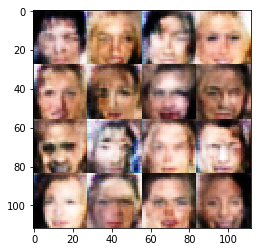

Epoch 1/1  Step 1025 ... Discriminator Loss: 1.4593  Generator Loss: 0.6021
Epoch 1/1  Step 1050 ... Discriminator Loss: 1.4343  Generator Loss: 0.7097
Epoch 1/1  Step 1075 ... Discriminator Loss: 1.4358  Generator Loss: 0.6404
Epoch 1/1  Step 1100 ... Discriminator Loss: 1.3263  Generator Loss: 0.7432


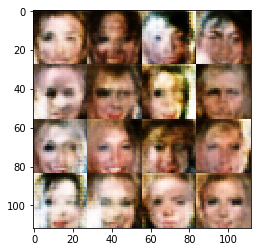

Epoch 1/1  Step 1125 ... Discriminator Loss: 1.5396  Generator Loss: 0.6349
Epoch 1/1  Step 1150 ... Discriminator Loss: 1.2900  Generator Loss: 0.6689
Epoch 1/1  Step 1175 ... Discriminator Loss: 1.3739  Generator Loss: 0.6600
Epoch 1/1  Step 1200 ... Discriminator Loss: 1.4491  Generator Loss: 0.5993


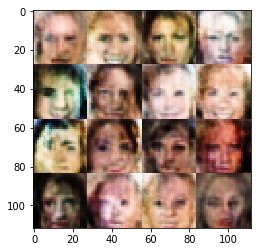

Epoch 1/1  Step 1225 ... Discriminator Loss: 1.4308  Generator Loss: 0.6827
Epoch 1/1  Step 1250 ... Discriminator Loss: 1.3501  Generator Loss: 0.7557
Epoch 1/1  Step 1275 ... Discriminator Loss: 1.2063  Generator Loss: 0.8485
Epoch 1/1  Step 1300 ... Discriminator Loss: 1.4643  Generator Loss: 0.5776


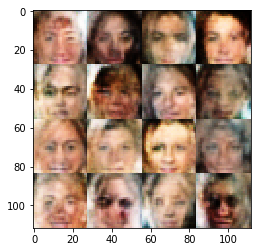

Epoch 1/1  Step 1325 ... Discriminator Loss: 1.2377  Generator Loss: 0.7657
Epoch 1/1  Step 1350 ... Discriminator Loss: 1.4495  Generator Loss: 0.6873
Epoch 1/1  Step 1375 ... Discriminator Loss: 1.3025  Generator Loss: 0.8148
Epoch 1/1  Step 1400 ... Discriminator Loss: 1.4540  Generator Loss: 0.7013


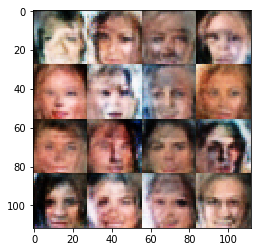

Epoch 1/1  Step 1425 ... Discriminator Loss: 1.3791  Generator Loss: 0.6122
Epoch 1/1  Step 1450 ... Discriminator Loss: 1.3589  Generator Loss: 0.7309
Epoch 1/1  Step 1475 ... Discriminator Loss: 1.3525  Generator Loss: 0.6159
Epoch 1/1  Step 1500 ... Discriminator Loss: 1.3315  Generator Loss: 0.6378


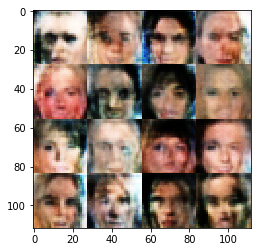

Epoch 1/1  Step 1525 ... Discriminator Loss: 1.2194  Generator Loss: 0.7327
Epoch 1/1  Step 1550 ... Discriminator Loss: 1.3682  Generator Loss: 0.6776
Epoch 1/1  Step 1575 ... Discriminator Loss: 1.3429  Generator Loss: 0.7531
Epoch 1/1  Step 1600 ... Discriminator Loss: 1.2611  Generator Loss: 0.7764


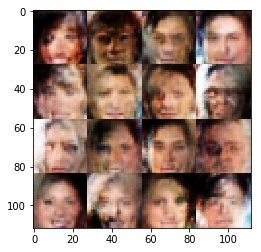

Epoch 1/1  Step 1625 ... Discriminator Loss: 1.2322  Generator Loss: 0.7481
Epoch 1/1  Step 1650 ... Discriminator Loss: 1.3042  Generator Loss: 0.6484
Epoch 1/1  Step 1675 ... Discriminator Loss: 1.4219  Generator Loss: 0.6337
Epoch 1/1  Step 1700 ... Discriminator Loss: 1.5314  Generator Loss: 0.5987


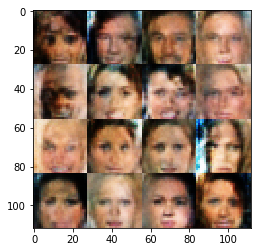

Epoch 1/1  Step 1725 ... Discriminator Loss: 1.3544  Generator Loss: 0.7846
Epoch 1/1  Step 1750 ... Discriminator Loss: 1.1481  Generator Loss: 0.9159
Epoch 1/1  Step 1775 ... Discriminator Loss: 1.3633  Generator Loss: 0.6060
Epoch 1/1  Step 1800 ... Discriminator Loss: 1.1860  Generator Loss: 0.7175


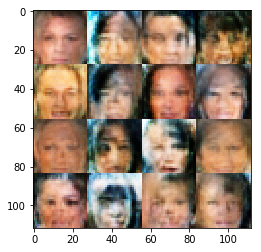

Epoch 1/1  Step 1825 ... Discriminator Loss: 1.3370  Generator Loss: 0.6723
Epoch 1/1  Step 1850 ... Discriminator Loss: 1.5888  Generator Loss: 0.5261
Epoch 1/1  Step 1875 ... Discriminator Loss: 1.4051  Generator Loss: 0.7187
Epoch 1/1  Step 1900 ... Discriminator Loss: 1.4882  Generator Loss: 0.4988


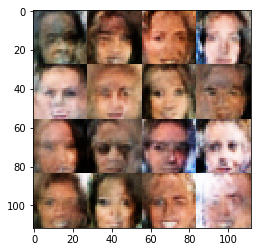

Epoch 1/1  Step 1925 ... Discriminator Loss: 1.3204  Generator Loss: 0.6421
Epoch 1/1  Step 1950 ... Discriminator Loss: 1.4267  Generator Loss: 0.6920
Epoch 1/1  Step 1975 ... Discriminator Loss: 1.3434  Generator Loss: 0.6401
Epoch 1/1  Step 2000 ... Discriminator Loss: 1.2316  Generator Loss: 0.7278


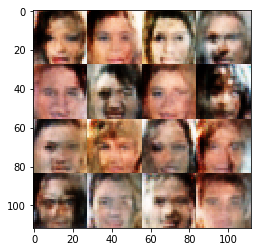

Epoch 1/1  Step 2025 ... Discriminator Loss: 1.2800  Generator Loss: 0.6522
Epoch 1/1  Step 2050 ... Discriminator Loss: 1.2247  Generator Loss: 0.7467
Epoch 1/1  Step 2075 ... Discriminator Loss: 1.3464  Generator Loss: 0.6318
Epoch 1/1  Step 2100 ... Discriminator Loss: 1.1418  Generator Loss: 0.8853


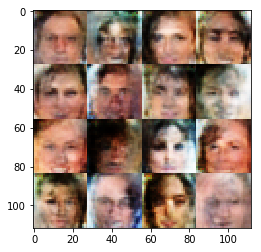

Epoch 1/1  Step 2125 ... Discriminator Loss: 1.4709  Generator Loss: 0.7967
Epoch 1/1  Step 2150 ... Discriminator Loss: 1.4573  Generator Loss: 0.5777
Epoch 1/1  Step 2175 ... Discriminator Loss: 1.3740  Generator Loss: 0.6589
Epoch 1/1  Step 2200 ... Discriminator Loss: 1.3485  Generator Loss: 0.6386


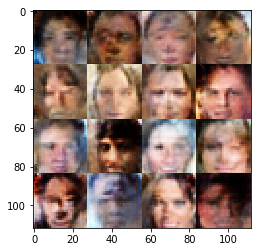

Epoch 1/1  Step 2225 ... Discriminator Loss: 1.5169  Generator Loss: 0.5345
Epoch 1/1  Step 2250 ... Discriminator Loss: 1.4695  Generator Loss: 0.5485
Epoch 1/1  Step 2275 ... Discriminator Loss: 1.3325  Generator Loss: 0.7618
Epoch 1/1  Step 2300 ... Discriminator Loss: 1.3776  Generator Loss: 0.7199


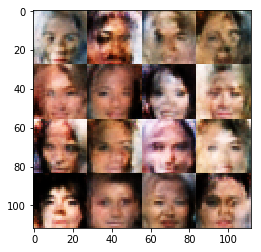

Epoch 1/1  Step 2325 ... Discriminator Loss: 1.3718  Generator Loss: 0.5879
Epoch 1/1  Step 2350 ... Discriminator Loss: 1.4447  Generator Loss: 0.5866
Epoch 1/1  Step 2375 ... Discriminator Loss: 1.4079  Generator Loss: 0.6763
Epoch 1/1  Step 2400 ... Discriminator Loss: 1.4684  Generator Loss: 0.5048


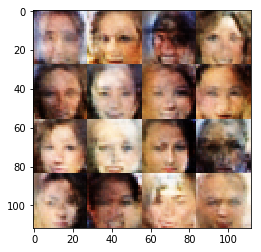

Epoch 1/1  Step 2425 ... Discriminator Loss: 1.3893  Generator Loss: 0.6130
Epoch 1/1  Step 2450 ... Discriminator Loss: 1.4438  Generator Loss: 0.6091
Epoch 1/1  Step 2475 ... Discriminator Loss: 1.2883  Generator Loss: 0.7360
Epoch 1/1  Step 2500 ... Discriminator Loss: 1.4465  Generator Loss: 0.6528


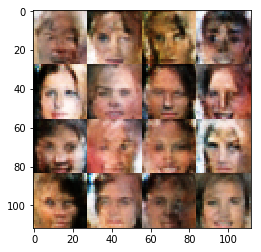

Epoch 1/1  Step 2525 ... Discriminator Loss: 1.4167  Generator Loss: 0.5669
Epoch 1/1  Step 2550 ... Discriminator Loss: 1.3196  Generator Loss: 0.6425
Epoch 1/1  Step 2575 ... Discriminator Loss: 1.4597  Generator Loss: 0.6428
Epoch 1/1  Step 2600 ... Discriminator Loss: 1.4706  Generator Loss: 0.5618


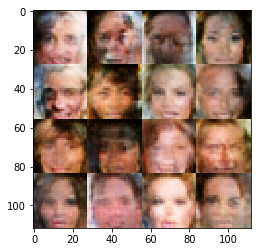

Epoch 1/1  Step 2625 ... Discriminator Loss: 1.4625  Generator Loss: 0.5812
Epoch 1/1  Step 2650 ... Discriminator Loss: 1.2959  Generator Loss: 0.7037
Epoch 1/1  Step 2675 ... Discriminator Loss: 1.4732  Generator Loss: 0.5274
Epoch 1/1  Step 2700 ... Discriminator Loss: 1.4291  Generator Loss: 0.6778


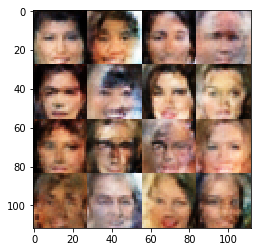

Epoch 1/1  Step 2725 ... Discriminator Loss: 1.3912  Generator Loss: 0.7121
Epoch 1/1  Step 2750 ... Discriminator Loss: 1.4064  Generator Loss: 0.6562
Epoch 1/1  Step 2775 ... Discriminator Loss: 1.4029  Generator Loss: 0.6859
Epoch 1/1  Step 2800 ... Discriminator Loss: 1.3836  Generator Loss: 0.6684


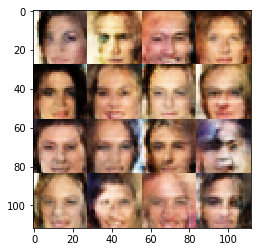

Epoch 1/1  Step 2825 ... Discriminator Loss: 1.4874  Generator Loss: 0.5120
Epoch 1/1  Step 2850 ... Discriminator Loss: 1.3451  Generator Loss: 0.6929
Epoch 1/1  Step 2875 ... Discriminator Loss: 1.3969  Generator Loss: 0.7156
Epoch 1/1  Step 2900 ... Discriminator Loss: 1.5240  Generator Loss: 0.5349


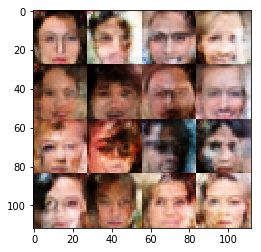

Epoch 1/1  Step 2925 ... Discriminator Loss: 1.4102  Generator Loss: 0.5923
Epoch 1/1  Step 2950 ... Discriminator Loss: 1.3813  Generator Loss: 0.6679
Epoch 1/1  Step 2975 ... Discriminator Loss: 1.4848  Generator Loss: 0.5895
Epoch 1/1  Step 3000 ... Discriminator Loss: 1.3677  Generator Loss: 0.6075


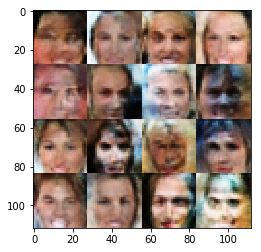

Epoch 1/1  Step 3025 ... Discriminator Loss: 1.3813  Generator Loss: 0.6231
Epoch 1/1  Step 3050 ... Discriminator Loss: 1.3791  Generator Loss: 0.7536
Epoch 1/1  Step 3075 ... Discriminator Loss: 1.4172  Generator Loss: 0.6332
Epoch 1/1  Step 3100 ... Discriminator Loss: 1.4287  Generator Loss: 0.5757


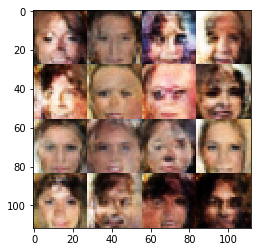

Epoch 1/1  Step 3125 ... Discriminator Loss: 1.4301  Generator Loss: 0.6314
Epoch 1/1  Step 3150 ... Discriminator Loss: 1.3263  Generator Loss: 0.6448
Epoch 1/1  Step 3175 ... Discriminator Loss: 1.3838  Generator Loss: 0.6421
Epoch 1/1  Step 3200 ... Discriminator Loss: 1.3448  Generator Loss: 0.6444


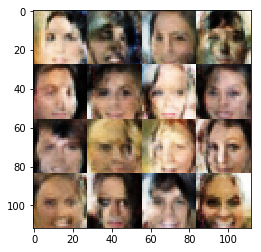

Epoch 1/1  Step 3225 ... Discriminator Loss: 1.5184  Generator Loss: 0.5663
Epoch 1/1  Step 3250 ... Discriminator Loss: 1.4753  Generator Loss: 0.6056
Epoch 1/1  Step 3275 ... Discriminator Loss: 1.4018  Generator Loss: 0.6640
Epoch 1/1  Step 3300 ... Discriminator Loss: 1.4635  Generator Loss: 0.6441


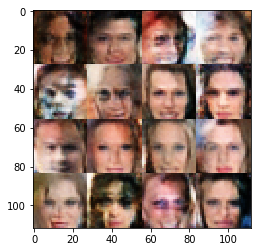

Epoch 1/1  Step 3325 ... Discriminator Loss: 1.3603  Generator Loss: 0.6330
Epoch 1/1  Step 3350 ... Discriminator Loss: 1.3735  Generator Loss: 0.7136
Epoch 1/1  Step 3375 ... Discriminator Loss: 1.3680  Generator Loss: 0.7397
Epoch 1/1  Step 3400 ... Discriminator Loss: 1.3614  Generator Loss: 0.6952


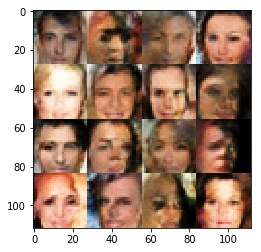

Epoch 1/1  Step 3425 ... Discriminator Loss: 1.3584  Generator Loss: 0.7287
Epoch 1/1  Step 3450 ... Discriminator Loss: 1.3146  Generator Loss: 0.6882
Epoch 1/1  Step 3475 ... Discriminator Loss: 1.3522  Generator Loss: 0.6824
Epoch 1/1  Step 3500 ... Discriminator Loss: 1.3187  Generator Loss: 0.7187


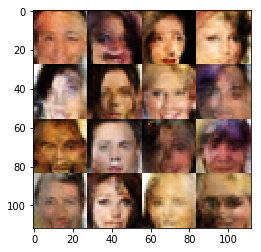

Epoch 1/1  Step 3525 ... Discriminator Loss: 1.4600  Generator Loss: 0.6143
Epoch 1/1  Step 3550 ... Discriminator Loss: 1.4813  Generator Loss: 0.6223
Epoch 1/1  Step 3575 ... Discriminator Loss: 1.4475  Generator Loss: 0.6902
Epoch 1/1  Step 3600 ... Discriminator Loss: 1.3924  Generator Loss: 0.6160


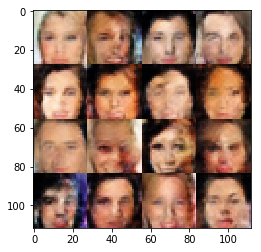

Epoch 1/1  Step 3625 ... Discriminator Loss: 1.2724  Generator Loss: 0.8310
Epoch 1/1  Step 3650 ... Discriminator Loss: 1.4220  Generator Loss: 0.5556
Epoch 1/1  Step 3675 ... Discriminator Loss: 1.3476  Generator Loss: 0.7152
Epoch 1/1  Step 3700 ... Discriminator Loss: 1.4143  Generator Loss: 0.6069


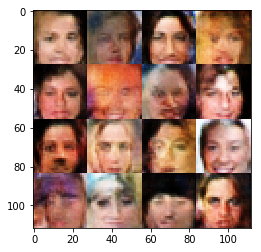

Epoch 1/1  Step 3725 ... Discriminator Loss: 1.3807  Generator Loss: 0.6820
Epoch 1/1  Step 3750 ... Discriminator Loss: 1.4090  Generator Loss: 0.6078
Epoch 1/1  Step 3775 ... Discriminator Loss: 1.3907  Generator Loss: 0.6988
Epoch 1/1  Step 3800 ... Discriminator Loss: 1.4475  Generator Loss: 0.5604


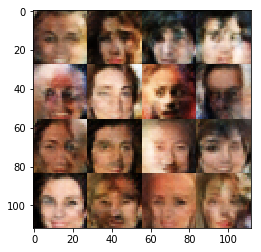

Epoch 1/1  Step 3825 ... Discriminator Loss: 1.4023  Generator Loss: 0.6719
Epoch 1/1  Step 3850 ... Discriminator Loss: 1.4413  Generator Loss: 0.5674
Epoch 1/1  Step 3875 ... Discriminator Loss: 1.2409  Generator Loss: 0.7427
Epoch 1/1  Step 3900 ... Discriminator Loss: 1.4389  Generator Loss: 0.6113


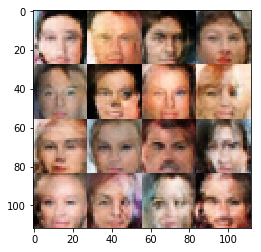

Epoch 1/1  Step 3925 ... Discriminator Loss: 1.3736  Generator Loss: 0.5736
Epoch 1/1  Step 3950 ... Discriminator Loss: 1.3430  Generator Loss: 0.6667
Epoch 1/1  Step 3975 ... Discriminator Loss: 1.3511  Generator Loss: 0.6912
Epoch 1/1  Step 4000 ... Discriminator Loss: 1.3510  Generator Loss: 0.6787


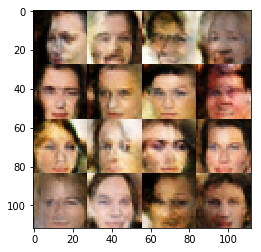

Epoch 1/1  Step 4025 ... Discriminator Loss: 1.3819  Generator Loss: 0.7340
Epoch 1/1  Step 4050 ... Discriminator Loss: 1.4187  Generator Loss: 0.6625
Epoch 1/1  Step 4075 ... Discriminator Loss: 1.4364  Generator Loss: 0.6269
Epoch 1/1  Step 4100 ... Discriminator Loss: 1.4094  Generator Loss: 0.5723


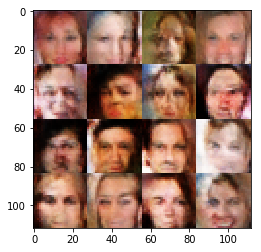

Epoch 1/1  Step 4125 ... Discriminator Loss: 1.4312  Generator Loss: 0.6721
Epoch 1/1  Step 4150 ... Discriminator Loss: 1.3836  Generator Loss: 0.6268
Epoch 1/1  Step 4175 ... Discriminator Loss: 1.3789  Generator Loss: 0.6080
Epoch 1/1  Step 4200 ... Discriminator Loss: 1.3857  Generator Loss: 0.5822


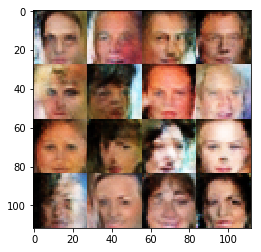

Epoch 1/1  Step 4225 ... Discriminator Loss: 1.4359  Generator Loss: 0.6147
Epoch 1/1  Step 4250 ... Discriminator Loss: 1.3425  Generator Loss: 0.6991
Epoch 1/1  Step 4275 ... Discriminator Loss: 1.6187  Generator Loss: 0.4212
Epoch 1/1  Step 4300 ... Discriminator Loss: 1.3231  Generator Loss: 0.6321


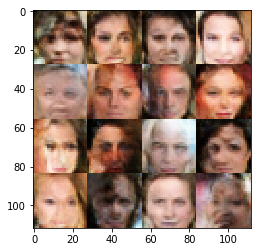

Epoch 1/1  Step 4325 ... Discriminator Loss: 1.5356  Generator Loss: 0.5314
Epoch 1/1  Step 4350 ... Discriminator Loss: 1.3456  Generator Loss: 0.5986
Epoch 1/1  Step 4375 ... Discriminator Loss: 1.3318  Generator Loss: 0.7247
Epoch 1/1  Step 4400 ... Discriminator Loss: 1.4359  Generator Loss: 0.6134


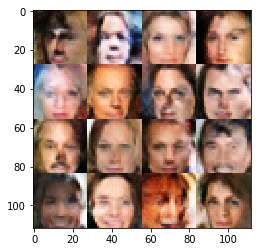

Epoch 1/1  Step 4425 ... Discriminator Loss: 1.3633  Generator Loss: 0.6986
Epoch 1/1  Step 4450 ... Discriminator Loss: 1.4098  Generator Loss: 0.6450
Epoch 1/1  Step 4475 ... Discriminator Loss: 1.2821  Generator Loss: 0.8478
Epoch 1/1  Step 4500 ... Discriminator Loss: 1.4754  Generator Loss: 0.6376


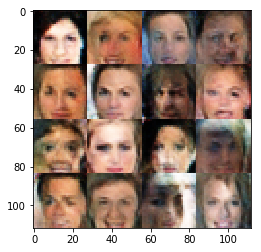

Epoch 1/1  Step 4525 ... Discriminator Loss: 1.3669  Generator Loss: 0.6603
Epoch 1/1  Step 4550 ... Discriminator Loss: 1.3574  Generator Loss: 0.6998
Epoch 1/1  Step 4575 ... Discriminator Loss: 1.4651  Generator Loss: 0.6380
Epoch 1/1  Step 4600 ... Discriminator Loss: 1.4078  Generator Loss: 0.7229


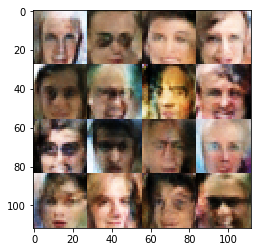

Epoch 1/1  Step 4625 ... Discriminator Loss: 1.3612  Generator Loss: 0.6735
Epoch 1/1  Step 4650 ... Discriminator Loss: 1.3566  Generator Loss: 0.6375
Epoch 1/1  Step 4675 ... Discriminator Loss: 1.3909  Generator Loss: 0.6538
Epoch 1/1  Step 4700 ... Discriminator Loss: 1.4056  Generator Loss: 0.5921


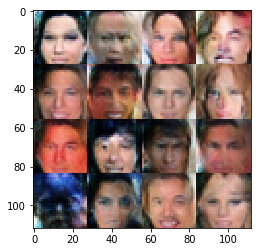

Epoch 1/1  Step 4725 ... Discriminator Loss: 1.5059  Generator Loss: 0.6211
Epoch 1/1  Step 4750 ... Discriminator Loss: 1.4617  Generator Loss: 0.6691
Epoch 1/1  Step 4775 ... Discriminator Loss: 1.3603  Generator Loss: 0.6794
Epoch 1/1  Step 4800 ... Discriminator Loss: 1.3706  Generator Loss: 0.6978


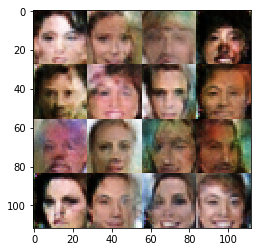

Epoch 1/1  Step 4825 ... Discriminator Loss: 1.3795  Generator Loss: 0.6704
Epoch 1/1  Step 4850 ... Discriminator Loss: 1.2849  Generator Loss: 0.7286
Epoch 1/1  Step 4875 ... Discriminator Loss: 1.4288  Generator Loss: 0.6321
Epoch 1/1  Step 4900 ... Discriminator Loss: 1.4786  Generator Loss: 0.6169


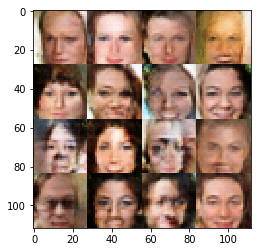

Epoch 1/1  Step 4925 ... Discriminator Loss: 1.5157  Generator Loss: 0.5300
Epoch 1/1  Step 4950 ... Discriminator Loss: 1.4349  Generator Loss: 0.6320
Epoch 1/1  Step 4975 ... Discriminator Loss: 1.3807  Generator Loss: 0.6258
Epoch 1/1  Step 5000 ... Discriminator Loss: 1.4193  Generator Loss: 0.6174


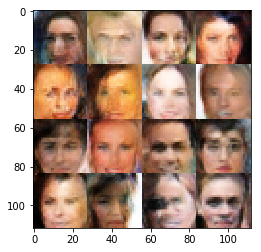

Epoch 1/1  Step 5025 ... Discriminator Loss: 1.3496  Generator Loss: 0.6928
Epoch 1/1  Step 5050 ... Discriminator Loss: 1.4967  Generator Loss: 0.5131
Epoch 1/1  Step 5075 ... Discriminator Loss: 1.3791  Generator Loss: 0.6061
Epoch 1/1  Step 5100 ... Discriminator Loss: 1.4334  Generator Loss: 0.6332


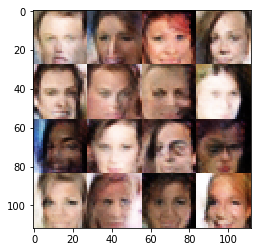

Epoch 1/1  Step 5125 ... Discriminator Loss: 1.4037  Generator Loss: 0.6275
Epoch 1/1  Step 5150 ... Discriminator Loss: 1.4527  Generator Loss: 0.6373
Epoch 1/1  Step 5175 ... Discriminator Loss: 1.3736  Generator Loss: 0.6645
Epoch 1/1  Step 5200 ... Discriminator Loss: 1.4058  Generator Loss: 0.6583


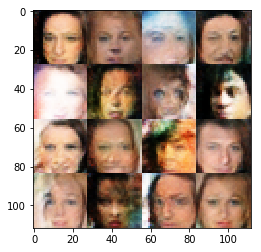

Epoch 1/1  Step 5225 ... Discriminator Loss: 1.3513  Generator Loss: 0.6834
Epoch 1/1  Step 5250 ... Discriminator Loss: 1.3413  Generator Loss: 0.6859
Epoch 1/1  Step 5275 ... Discriminator Loss: 1.4211  Generator Loss: 0.6997
Epoch 1/1  Step 5325 ... Discriminator Loss: 1.6053  Generator Loss: 0.5209
Epoch 1/1  Step 5350 ... Discriminator Loss: 1.4795  Generator Loss: 0.6351
Epoch 1/1  Step 5375 ... Discriminator Loss: 1.4003  Generator Loss: 0.6038
Epoch 1/1  Step 5400 ... Discriminator Loss: 1.3877  Generator Loss: 0.6640


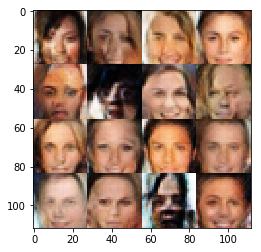

Epoch 1/1  Step 5425 ... Discriminator Loss: 1.4609  Generator Loss: 0.6326
Epoch 1/1  Step 5450 ... Discriminator Loss: 1.3959  Generator Loss: 0.6479
Epoch 1/1  Step 5475 ... Discriminator Loss: 1.4620  Generator Loss: 0.5419
Epoch 1/1  Step 5500 ... Discriminator Loss: 1.4107  Generator Loss: 0.6170


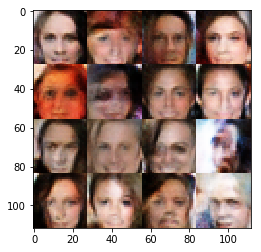

Epoch 1/1  Step 5525 ... Discriminator Loss: 1.3425  Generator Loss: 0.6372
Epoch 1/1  Step 5550 ... Discriminator Loss: 1.2595  Generator Loss: 0.7011
Epoch 1/1  Step 5575 ... Discriminator Loss: 1.4378  Generator Loss: 0.6557
Epoch 1/1  Step 5600 ... Discriminator Loss: 1.4232  Generator Loss: 0.6822


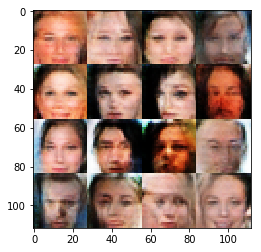

Epoch 1/1  Step 5625 ... Discriminator Loss: 1.4427  Generator Loss: 0.5955
Epoch 1/1  Step 5650 ... Discriminator Loss: 1.4138  Generator Loss: 0.5919
Epoch 1/1  Step 5675 ... Discriminator Loss: 1.4457  Generator Loss: 0.6528
Epoch 1/1  Step 5700 ... Discriminator Loss: 1.4762  Generator Loss: 0.5701


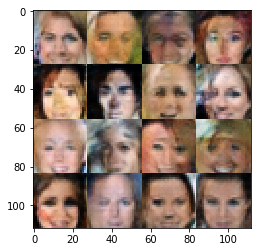

Epoch 1/1  Step 5725 ... Discriminator Loss: 1.4322  Generator Loss: 0.7032
Epoch 1/1  Step 5750 ... Discriminator Loss: 1.4293  Generator Loss: 0.6760
Epoch 1/1  Step 5775 ... Discriminator Loss: 1.3227  Generator Loss: 0.6754
Epoch 1/1  Step 5800 ... Discriminator Loss: 1.4611  Generator Loss: 0.6218


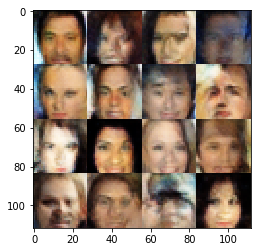

Epoch 1/1  Step 5825 ... Discriminator Loss: 1.4879  Generator Loss: 0.6632
Epoch 1/1  Step 5850 ... Discriminator Loss: 1.4958  Generator Loss: 0.5992
Epoch 1/1  Step 5875 ... Discriminator Loss: 1.4213  Generator Loss: 0.6451
Epoch 1/1  Step 5900 ... Discriminator Loss: 1.4470  Generator Loss: 0.5828


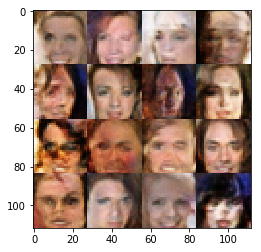

Epoch 1/1  Step 5925 ... Discriminator Loss: 1.4368  Generator Loss: 0.6581
Epoch 1/1  Step 5950 ... Discriminator Loss: 1.3927  Generator Loss: 0.6119
Epoch 1/1  Step 5975 ... Discriminator Loss: 1.4581  Generator Loss: 0.6387
Epoch 1/1  Step 6000 ... Discriminator Loss: 1.4008  Generator Loss: 0.6714


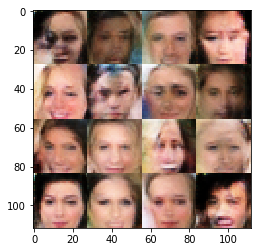

Epoch 1/1  Step 6025 ... Discriminator Loss: 1.3398  Generator Loss: 0.6412
Epoch 1/1  Step 6050 ... Discriminator Loss: 1.4730  Generator Loss: 0.6293
Epoch 1/1  Step 6075 ... Discriminator Loss: 1.4438  Generator Loss: 0.6153
Epoch 1/1  Step 6100 ... Discriminator Loss: 1.4195  Generator Loss: 0.6860


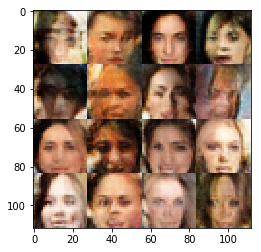

Epoch 1/1  Step 6125 ... Discriminator Loss: 1.4500  Generator Loss: 0.6332
Epoch 1/1  Step 6150 ... Discriminator Loss: 1.4690  Generator Loss: 0.5578
Epoch 1/1  Step 6175 ... Discriminator Loss: 1.4156  Generator Loss: 0.6380
Epoch 1/1  Step 6200 ... Discriminator Loss: 1.3948  Generator Loss: 0.6318


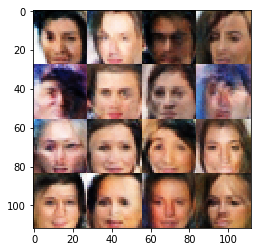

Epoch 1/1  Step 6225 ... Discriminator Loss: 1.3890  Generator Loss: 0.7171
Epoch 1/1  Step 6250 ... Discriminator Loss: 1.4152  Generator Loss: 0.6609
Epoch 1/1  Step 6275 ... Discriminator Loss: 1.4207  Generator Loss: 0.5993
Epoch 1/1  Step 6300 ... Discriminator Loss: 1.5170  Generator Loss: 0.6389


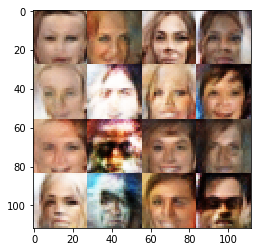

Epoch 1/1  Step 6325 ... Discriminator Loss: 1.4611  Generator Loss: 0.6090


In [ ]:
batch_size = 32
z_dim = 64
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.

In [ ]:
print('done!!!')

done!!!
